In [ ]:
#Bibliotecas
#Manipulação dos dados
import pandas as pd 
import numpy as np

#Visualização
import matplotlib.pyplot as plt 
import seaborn as sns

# Processamento de linguagem natural(NLP)
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('portuguese')
from nltk.tokenize import word_tokenize
import re
from unidecode import unidecode

#Formas de tokenização 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score,classification_report, recall_score, f1_score, confusion_matrix,balanced_accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight


#Deploy
import joblib
from contextlib import redirect_stdout

In [ ]:
import unidecode

In [ ]:
unidecode.__version__

AttributeError: module 'unidecode' has no attribute '__version__'

In [ ]:
from google.cloud import bigquery

In [ ]:
#Conexão com bigquery 
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [ ]:
# #Extraindo o dataset 
# %%bigquery df
# SELECT 
#     idConsulta, 
#     idBeneficiario,
#     motivoConsulta 
#     FROM `laboratorio-eng-dados.fenix_raw.pa_digital_full`

In [ ]:
def read_query(path_to_query):
    '''path_to_query: /path/to/query'''
    query_read = open(path_to_query, 'r', encoding='utf-8')
    sql_query = query_read.read()
    query_read.close()
    
    return sql_query

In [ ]:
query_path = '../queries/query_pa_digital.txt'
sql_query = read_query(query_path)
sql_query

'SELECT \n    idConsulta\n    , idBeneficiario\n    , motivoConsulta \n    FROM `{project}.{dataset}.{table}`'

In [ ]:
from google.cloud import bigquery

def bq_query_to_df(query, project, dataset, table, credentials):
    '''query: query on bq
       project: gcp project_id
       dataset: bq dataset_id
       table: bq table_id
       credentials: path/to/.json'''
    
    query = query.format(project=project, dataset=dataset, table=table)
    client = bigquery.Client.from_service_account_json(json_credentials_path=credentials)
    results_df = client.query(query).to_dataframe()
    
    return results_df

In [ ]:
df = bq_query_to_df(query = sql_query, 
               project = 'laboratorio-eng-dados', 
               dataset = 'fenix_raw', 
               table = 'pa_digital_full',
               credentials = '../../prod/src/config/gcloud_credentials_dev.json')

In [ ]:
def format_df():
  '''Formata o dataset com os campos de interesse'''
  pa_digital = df.copy()
  pa_digital.set_index(['idBeneficiario', 'idConsulta'], inplace=True)
  return pa_digital

formated_df = format_df()

In [ ]:
def select_nulls(df):
  '''Função que seleciona os atendimentos com campo motivoConsulta nulos'''
  nulos = df[df["motivoConsulta"].isnull()| df["motivoConsulta"].isin(['null', ''," "])]
  nulos = nulos
  return nulos.drop(columns='motivoConsulta') 


nulos = select_nulls(formated_df)

In [ ]:
# col = 'motivoConsulta'

# df[(df[col].str.len()>=2) & \
#    (df[col] != "null") & \
#    (df[col] != " ")] \
#   .dropna(subset=[col])

In [ ]:
def cleaning_df(df):
  '''Deleta nulos'''
  #deletando nulos/'null's 
  dataframe = df[df['motivoConsulta'].str.len()>=2]\
              .query('motivoConsulta != "null"')\
              .query('motivoConsulta != " "')\
              .dropna(subset=['motivoConsulta'])
  return dataframe

    #Aplicando a função 
cleaned_df = cleaning_df(formated_df)

In [ ]:
def preprocessing(df):
  '''Pre processamento do dataframe'''

  df['motivoConsulta'] = df['motivoConsulta'].apply(lambda x: re.sub('[0-9]|,|\.|/|$|\(|\)|-|\+|:|•', ' ', x))\
                                  .apply(lambda x: unidecode(x)).str.lower()\
                                  .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df["tokens"] = df['motivoConsulta'].apply(nltk.word_tokenize)\
                                  .apply(', '.join) 
                                                
  return df

  #Aplicando a função 
processed_df=preprocessing(cleaned_df)

In [ ]:
processed_df

motivoConsulta  \
idBeneficiario idConsulta                                                      
27635656       167314                                                 dengue   
27762938       171016            sintomas gripais portanto preocupacao covid   
27762585       171155          muita coriza nasal espirros cansaco mal estar   
27815444       175136                     quero encaminhamento nutricionista   
2400328        179081                                                  covid   
...                                                                      ...   
5690606        181390         preciso encaminhamento psicologo covid ansioso   
27414695       184850                         febre tosse cansaco dor costas   
27952433       184933                                       sintomas alergia   
27950773       184804                                         diarreia febre   
15299109       188418      tosse garganta seca dores corpo falta apetite ...   

                                                                      tokens  
idBeneficiario idConsulta                                                     
27635656       167314                                                 dengue  
27762938       171016        sintomas, gripais, portanto, preocupacao, covid  
27762585       171155      muita, coriza, nasal, espirros, cansaco, mal, ...  
27815444       175136                   quero, encaminhamento, nutricionista  
2400328        179081                                                  covid  
...                                                                      ...  
5690606        181390      preciso, encaminhamento, psicologo, covid, ans...  
27414695       184850                     febre, tosse, cansaco, dor, costas  
27952433       184933                                      sintomas, alergia  
27950773       184804                                        diarreia, febre  
15299109       188418      tosse, garganta, seca, dores, corpo, falta, ap...  

[246318 rows x 2 columns]

In [ ]:
dict_pa = pd.read_csv('../data/dict_pa.csv').fillna('-')

In [ ]:
for target in dict_pa.columns:
    processed_df.loc[processed_df['tokens'].str.contains('|'.join(dict_pa[target])), 'target'] = target   

In [ ]:
processed_df['target'].fillna('outros',inplace= True)

In [ ]:
processed_df.groupby('target').size()

target
covid               64410
gastro              13368
gravidez             1338
mental               7518
oftalmo              6132
orto                10254
outros              68214
sintomas_gripais    75084
dtype: int64

In [ ]:
def create_target(df):
  '''Criação dos targets com as condições de motivo de atendimento'''

  #Dicionário das condições do PA digital
  dict_pa = pd.read_csv('../data/dict_pa.csv').fillna('-')
  #Aplicação dos targets a partir dos dicionários de condições
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['mental'])), 'target'] = "mental"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['gastro'])), 'target'] = "gastro"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['covid'])), 'target'] = "covid"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['gravidez'])), 'target'] = "gravidez"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['sintomas_gripais'])), 'target'] = "sintomas_gripais"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['oftalmo'])), 'target'] = "oftalmo"
  df.loc[df['tokens'].str.contains('|'.join(dict_pa['orto'])), 'target'] = "orto"
  df['target'].fillna('outros',inplace= True)
    
  return df


#Aplicando a função 
final_df = create_target(processed_df)

In [ ]:
#Visualizando dataset pronto para entrada do modelo 
final_df.head(5)

motivoConsulta  \
idBeneficiario idConsulta                                                  
27635656       167314                                             dengue   
27762938       171016        sintomas gripais portanto preocupacao covid   
27762585       171155      muita coriza nasal espirros cansaco mal estar   
27815444       175136                 quero encaminhamento nutricionista   
2400328        179081                                              covid   

                                                                      tokens  \
idBeneficiario idConsulta                                                      
27635656       167314                                                 dengue   
27762938       171016        sintomas, gripais, portanto, preocupacao, covid   
27762585       171155      muita, coriza, nasal, espirros, cansaco, mal, ...   
27815444       175136                   quero, encaminhamento, nutricionista   
2400328        179081                                                  covid   

                                     target  
idBeneficiario idConsulta                    
27635656       167314                outros  
27762938       171016      sintomas_gripais  
27762585       171155      sintomas_gripais  
27815444       175136                outros  
2400328        179081                 covid

                  precision    recall  f1-score   support

           covid       0.39      0.91      0.55     16103
          gastro       0.57      0.48      0.52      3446
        gravidez       0.89      1.00      0.94       271
          mental       0.61      0.65      0.63      1776
         oftalmo       0.57      0.75      0.65      1537
            orto       0.81      0.80      0.81      2563
          outros       0.84      0.42      0.56     17054
sintomas_gripais       0.83      0.27      0.41     18830

        accuracy                           0.54     61580
       macro avg       0.69      0.66      0.64     61580
    weighted avg       0.69      0.54      0.53     61580

precision average macro 0.6917636001106349
recall average macro 0.6621250904932217
f1 score average macro 0.6350689987512539
accuracy 0.5412309191295875
cross validation {'fit_time': array([104.13029528, 106.82275581, 108.09318733, 106.50164652,
       103.12316298]), 'score_time': array([1.10130048,

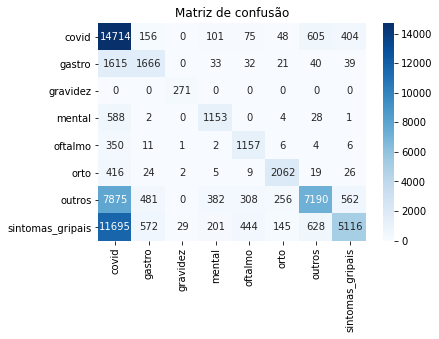

In [ ]:
# #Divisão entre treino e teste 
# X = final_df.tokens
# y = final_df.target
# X_train, X_test, y_train, y_test= train_test_split(X, y, stratify = y, random_state=42, test_size=0.25)


# #Cálculo do class weight pelo método compute_class_weight - Estimate class weights for unbalanced datasets.
# target=final_df['target'].tolist()   
# classes=np.unique(target)           
# class_weights=class_weight.compute_class_weight(class_weight ='balanced',classes= classes,y=target)
# class_weights = dict(zip(classes,class_weights))


# #Pipeline de treino
# logreg = Pipeline([('vect', CountVectorizer(max_df=500)),
#                 ('tfidf', TfidfTransformer()),
#                 ('clf', LogisticRegression(multi_class='multinomial',class_weight=class_weights,max_iter=1000))
#                ])
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

# #Gerando o joblib do modelo
# #joblib.dump(logreg, 'model.pkl', compress = 1) 

# #Criando o arquivo de métricas
# #with open("metrics.txt", 'w') as f:
#   #with redirect_stdout(f):
# print(classification_report(y_test, y_pred))
# print('precision average macro %s' %precision_score(y_test, y_pred, average='macro'))
# print('recall average macro %s' %recall_score(y_test, y_pred, average='macro')) 
# print('f1 score average macro %s' %f1_score(y_test, y_pred, average='macro'))
# print('accuracy %s' % accuracy_score(y_test, y_pred))
#     #Validação cruzada
# scoring = ['precision_macro', 'f1_macro']
# print('cross validation %s' %cross_validate(logreg, X,y, cv=5,scoring=['f1_macro','precision_macro']))
# #Matriz de confusão
# cm = confusion_matrix(y_test,y_pred)
# plt.title('Matriz de confusão')
# sns.heatmap(cm, annot=True,cmap='Blues', fmt='g',xticklabels=(classes),yticklabels=(classes))
    

In [ ]:
#Divisão entre treino e teste 
X = final_df.tokens
y = final_df.target
X_train, X_test, y_train, y_test= train_test_split(X, y, stratify = y, random_state=42, test_size=0.25)


#Cálculo do class weight pelo método compute_class_weight - Estimate class weights for unbalanced datasets.
target=final_df['target'].tolist()   
classes=np.unique(target)           
class_weights=class_weight.compute_class_weight(class_weight ='balanced',classes= classes,y=target)
class_weights = dict(zip(classes,class_weights))


#Pipeline de treino
logreg = Pipeline([('vect', CountVectorizer(max_df=500)),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(multi_class='multinomial',class_weight=class_weights,max_iter=1000))
               ])
logreg.fit(X_train, y_train)    

Pipeline(steps=[('vect', CountVectorizer(max_df=500)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 LogisticRegression(class_weight={'covid': 0.4780274802049371,
                                                  'gastro': 2.234055289508054,
                                                  'gravidez': 28.351519337016576,
                                                  'mental': 4.334142736486487,
                                                  'oftalmo': 5.006463414634147,
                                                  'orto': 3.0027062609713284,
                                                  'outros': 0.4513699533820037,
                                                  'sintomas_gripais': 0.4087967019835896},
                                    max_iter=1000,
                                    multi_class='multinomial'))])

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
classification_report(y_test, y_pred)

'                  precision    recall  f1-score   support\n\n           covid       0.39      0.91      0.55     16103\n          gastro       0.57      0.48      0.52      3446\n        gravidez       0.89      1.00      0.94       271\n          mental       0.61      0.65      0.63      1776\n         oftalmo       0.57      0.75      0.65      1537\n            orto       0.81      0.80      0.81      2563\n          outros       0.84      0.42      0.56     17054\nsintomas_gripais       0.83      0.27      0.41     18830\n\n        accuracy                           0.54     61580\n       macro avg       0.69      0.66      0.64     61580\n    weighted avg       0.69      0.54      0.53     61580\n'

In [ ]:
precision_score(y_test, y_pred, average='macro')

0.6917636001106349

In [ ]:
recall_score(y_test, y_pred, average='macro')

0.6621250904932217

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.6350689987512539

In [ ]:
accuracy_score(y_test, y_pred)

0.5412309191295875

In [ ]:
cross_validate(logreg, X,y, cv=5,scoring=['f1_macro','precision_macro'])

{'fit_time': array([106.09197402, 102.44803166, 102.61990643, 106.87186718,
         99.35228252]),
 'score_time': array([1.11068797, 1.1129756 , 1.09873271, 1.11435914, 1.13268876]),
 'test_f1_macro': array([0.64057055, 0.64066441, 0.63372213, 0.63944369, 0.63271615]),
 'test_precision_macro': array([0.70232775, 0.70224319, 0.69658244, 0.7004888 , 0.69188614])}

In [ ]:
cross_validation_results = cross_validate(logreg, X,y, cv=2, scoring=['balanced_accuracy', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

In [ ]:
cross_validation_results = pd.DataFrame.from_dict(cross_validation_results)

In [ ]:
cross_validation_results.to_csv('xx.csv', index = False, sep = ';', decimal = ',')

fit_time  score_time  test_balanced_accuracy  test_accuracy  \
0  61.225509    4.519794                0.719208       0.582126   
1  61.612027    4.497142                0.719208       0.582126   

   test_precision_macro  test_recall_macro  test_f1_macro  
0              0.720961           0.719208       0.682492  
1              0.720961           0.719208       0.682492

In [ ]:
cm = confusion_matrix(y_test,y_pred)

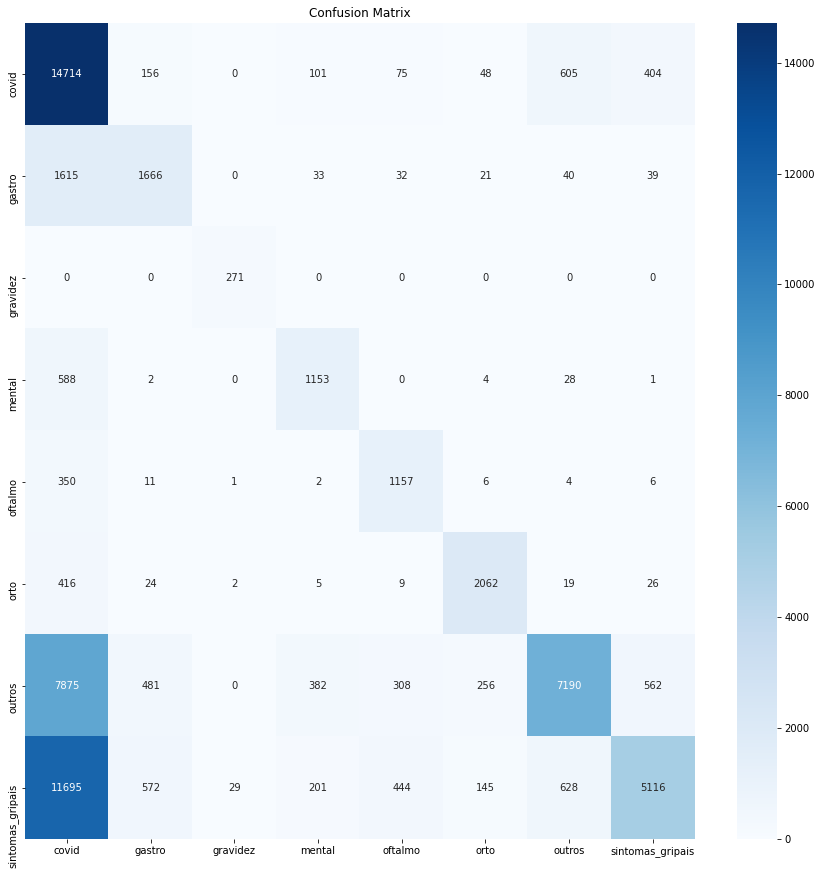

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True,cmap='Blues', fmt='g',xticklabels=(classes),yticklabels=(classes))
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_results.png')

In [ ]:
y_pred = logreg.predict(X_test)

#Gerando o joblib do modelo
#joblib.dump(logreg, 'model.pkl', compress = 1) 

#Criando o arquivo de métricas
#with open("metrics.txt", 'w') as f:
  #with redirect_stdout(f):
print(classification_report(y_test, y_pred))
print('precision average macro %s' %precision_score(y_test, y_pred, average='macro'))
print('recall average macro %s' %recall_score(y_test, y_pred, average='macro')) 
print('f1 score average macro %s' %f1_score(y_test, y_pred, average='macro'))
print('accuracy %s' % accuracy_score(y_test, y_pred))
    #Validação cruzada
scoring = ['precision_macro', 'f1_macro']
print('cross validation %s' %cross_validate(logreg, X,y, cv=5,scoring=['f1_macro','precision_macro']))
#Matriz de confusão
cm = confusion_matrix(y_test,y_pred)
plt.title('Matriz de confusão')
sns.heatmap(cm, annot=True,cmap='Blues', fmt='g',xticklabels=(classes),yticklabels=(classes))


In [ ]:
def output_table():
  '''cria tabela com as predições'''
  y_pred = logreg.predict(X)
  table = pd.DataFrame(y_pred, index=X.index, columns=['classificacao'])
  full_table = table.append(nulos).fillna('indefinido por falta de preenchimento')
  return full_table 

In [ ]:
#Tabela com as predições finais do modelo
output_table()

classificacao
idBeneficiario   idConsulta                                       
27635656         167314                                     outros
27762938         171016                           sintomas_gripais
27762585         171155                                      covid
27815444         175136                                      covid
2400328          179081                                      covid
...                                                            ...
6053957891784704 130202      indefinido por falta de preenchimento
5024796888793088 153670      indefinido por falta de preenchimento
4948696644976640 153514      indefinido por falta de preenchimento
4897933052870656 158090      indefinido por falta de preenchimento
5433873330601984 157992      indefinido por falta de preenchimento

[802572 rows x 1 columns]